In [132]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pickle
import matplotlib.pyplot as plt
import lightgbm as lgb
import numpy as np

In [133]:
bp_df = pd.read_csv('../Data/benchpress/benchpress_coords.csv')
dl_df = pd.read_csv('../Data/deadlift/deadlift_coords.csv')
sq_df = pd.read_csv('../Data/squat/squat_coords.csv')

In [134]:
sq_df.columns = sq_df.columns.str.strip()

label_encoder = LabelEncoder()
sq_df["class"] = label_encoder.fit_transform(sq_df["class"])

X = sq_df.drop(columns=["class"])
y = sq_df["class"]

X = X.apply(pd.to_numeric, errors="coerce")
X.fillna(0, inplace=True)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [136]:
model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    min_data_in_leaf=20,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    objective='multiclass',
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train),(X_test, y_test)],
    eval_metric=["multi_logloss"],
    callbacks=[
        lgb.early_stopping(stopping_rounds=20),
        lgb.log_evaluation(period=1)
    ]
)

[1]	training's multi_logloss: 1.82513	valid_1's multi_logloss: 1.84521
Training until validation scores don't improve for 20 rounds
[2]	training's multi_logloss: 1.62884	valid_1's multi_logloss: 1.65345
[3]	training's multi_logloss: 1.46045	valid_1's multi_logloss: 1.49173
[4]	training's multi_logloss: 1.31887	valid_1's multi_logloss: 1.35937
[5]	training's multi_logloss: 1.19988	valid_1's multi_logloss: 1.24532
[6]	training's multi_logloss: 1.09642	valid_1's multi_logloss: 1.14897
[7]	training's multi_logloss: 1.00384	valid_1's multi_logloss: 1.06237
[8]	training's multi_logloss: 0.923309	valid_1's multi_logloss: 0.983945
[9]	training's multi_logloss: 0.851665	valid_1's multi_logloss: 0.914205
[10]	training's multi_logloss: 0.7866	valid_1's multi_logloss: 0.853027
[11]	training's multi_logloss: 0.726899	valid_1's multi_logloss: 0.794526
[12]	training's multi_logloss: 0.670771	valid_1's multi_logloss: 0.739704
[13]	training's multi_logloss: 0.62395	valid_1's multi_logloss: 0.693209
[14

LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.8,
               learning_rate=0.05, min_data_in_leaf=20, n_estimators=1000,
               objective='multiclass', random_state=42)

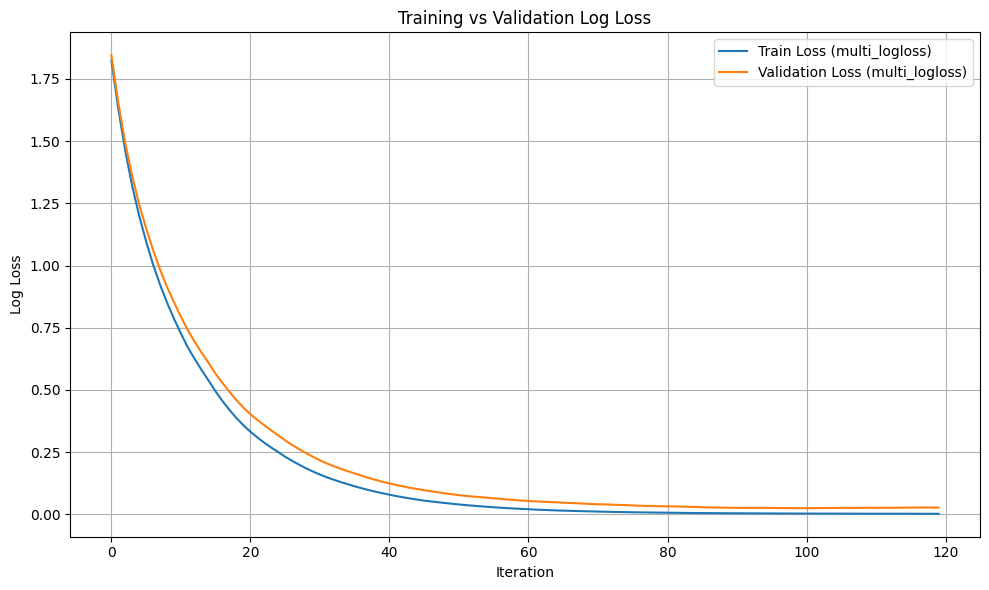

In [137]:
evals_result = model.evals_result_

train_loss = evals_result['training']['multi_logloss']
val_loss = evals_result['valid_1']['multi_logloss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss (multi_logloss)')
plt.plot(val_loss, label='Validation Loss (multi_logloss)')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Training vs Validation Log Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("Accuracy:", acc)

y_pred_label = label_encoder.inverse_transform(y_pred)

Accuracy: 0.9946236559139785


In [139]:
with open('./other/sq_lightgbm.pkl', 'wb') as f:
    pickle.dump(model, f)